[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KJohnmar/INL-OBELIX-2026/blob/main/sp3-model/cubic-lattice/sp3-model-CubicLattice.ipynb)

## __Environment Setup For Computational Physics and Data Visualization__

In [ ]:
%%capture --no-display
!pip install -i https://test.pypi.org/simple/ pybinding

In [ ]:
%%capture --no-display
!apt-get install texlive texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
# ==============================================================================
# 1. Environment Control & Warning Management
import warnings
warnings.filterwarnings("ignore")
# ==============================================================================
# 2. System & OS Utilities
import os
import os.path
import logging
import re
import itertools
# ==============================================================================
# 3. Numerical Computing & Data Manipulation (The "SciPy Stack")
import numpy as np
import pandas as pd
import math
# ==============================================================================
# 4. Computational Physics & Scientific Calculations
import pybinding as pb
from scipy.interpolate import griddata
import scipy.integrate as itg
# ==============================================================================
# 5. Data Visualization & Styling
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from matplotlib import rc
import matplotlib.patheffects as path_effects
from matplotlib.collections import LineCollection
import matplotlib.image as mpimg
# ==============================================================================
# 6. Advanced Plotting Components
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.offsetbox import (
    AnchoredOffsetbox, AuxTransformBox, DrawingArea, TextArea, VPacker)
from matplotlib import transforms
# ==============================================================================
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configure LaTeX to use Times New Roman.
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Times New Roman"],
    "mathtext.fontset": "custom",
    "mathtext.rm": "Times New Roman",
    "mathtext.it": "Times New Roman:italic",
    "mathtext.bf": "Times New Roman:bold",
    "text.latex.preamble": r"""
        \usepackage{amsmath}
        \usepackage{xfrac}
    """
})

$\def\bra#1{\mathinner{\langle{#1}|}}
\def\ket#1{\mathinner{|{#1}\rangle}}
\def\braket#1#2{\mathinner{\langle{#1}|{#2}\rangle}}$

## __Project Goal:__ $sp³$-model using Chebyshev Polynomials (Quantum-Kite)

## __$sp³$-model in Cubic lattice__
<font color="red">

1. [x] __Tight-Binding Formalism__
    - [x] The Basis Set
    - [x] The Tight-Binding Hamiltonian
2. [x] __Spin-Orbit Coupling__
    - [x] The Expanded Basis
    - [x] The SOC Hamiltonian
3. [x] __Slater-Koster Approximation__
    - [x] Hamiltoniam Matrix Elements
        - [x] Real-Space Matrix Elements
        - [x] Reciprocal-Space Matrix Elements
    - [x] Band Structure (plot)
        - [x] Analytically
        - [x] Diagonalization using Pybinding
    - [_] Density of States (Chebyshev Polynomials)
4. [x] __Hall Conductiviy__
    - [x] Theoretical Background
    - [x] Implementation Steps
    - [_] Hall Conductivity (Chebyshev Polynomials)
5. [_] __Disorder Effects on Orbital Hall Transport Using Chebyshev Expansion__
    - [_] Anderson-like site potential fluctuations
    - [_] Vacancies
    - [_] Bond disorder

</font>

<h1 align="center"></h1>

___
# <center>**$sp^3$-model in Cubic Lattice**</center>
___

<p align="center">
  <b><i>The $sp^3$ tight-binding model is a fundamental framework for describing the electronic structure of group IV semiconductors (like Silicon or Germanium) and other cubic systems.</i></b>
</p>


The $sp^{3}$ model considers four atomic orbitals per site:
- One $s$-orbital ($\ket{s}$)
- Three $p$-orbitals ($\ket{p_x}$, $\ket{p_y}$, $\ket{p_z}$)
___


## __1. Tight-Binding Formalism__

### __A. <u>The Basis Set</u>__

The Bloch basis functions are:
$$
\ket{\phi_m, \mathbf{k}} = \dfrac{1}{\sqrt{N}}\sum_{{\rm R}_i}e^{i{\rm k}⋅{\rm R}_i}\ket{\phi_m, \mathbf{R}_i}
$$
where $m ∈ {s,p_x​,p_y​,p_z​}$

At each lattice site $\mathbf{R}_{i}$, the basis is defined by the state vector:
$$
\Psi_{\mathbf{k}} =
\begin{pmatrix}
    \ket{s, \mathbf{k}} \\
    \ket{p_x, \mathbf{k}} \\
    \ket{p_y, \mathbf{k}} \\
    \ket{p_z, \mathbf{k}}
\end{pmatrix}
$$

### __B. <u>The Tight-Binding Hamiltonian</u>__

The Hamiltonian is an $4\times4$ matrix $H(\mathbf{k})$. It consists of __on-site energies__ $(E_s​,E_p​)$ and __hopping integrals__ between nearest neighbors.

The general form of the matrix is:
$$
H(\mathbf{k}) =
\begin{pmatrix}
    H_{ss}    & H_{sp_x}    & H_{sp_y}    & H_{sp_z}   \\
    H_{p_xs}  & H_{p_xp_x}  & 0           & 0          \\
    H_{p_ys}  & 0           & H_{p_yp_y}  & 0          \\
    H_{p_zs}  & 0           & 0           & H_{p_zp_z} \\
\end{pmatrix}
$$

- In nearest neighbors of the **simple cubic**, the oof-diagonal terms $H_{p_ip_j}$ are actually zero beacuse the neighbors lie only along the axes (where direction cosines $l\cdot m=0$).
- In **Diamond/Zinc-blende**, all diagonal terms $H_{p_ip_j}$ are non-zero because the nearest neighbors are at tetrahedral positions like $(\frac{1}{4}, \frac{1}{4}, \frac{1}{4})$, where $l,m,n \neq 0$.
___


## **2. Spin-Orbit Coupling**

To include __Spin-Orbit Coupling (SOC)__ in your $sp^3$ tight-binding model, you must double the size of your basis to account for the two possible spin states (up $\uparrow$ and down $\downarrow$) of each orbital.

### __A. <u>The Expanded Basis</u>__

The new basis set contains 8 states (4 orbitals $\times$ 2 spins):
$$
{\mathscr{B}} =
\{ \ket{s, \uparrow}, \ket{p_x, \uparrow}, \ket{p_y, \uparrow}, \ket{p_z, \uparrow}, \ket{s, \downarrow}, \ket{p_x, \downarrow}, \ket{p_y, \downarrow}, \ket{p_z, \downarrow}
\}
$$
and the state vetor is
$$
\Psi_{\mathbf{k}}^{\rm SOC} =
\begin{pmatrix}
    \Psi_{\mathbf{k},\uparrow} \\
    \Psi_{\mathbf{k},\downarrow}
\end{pmatrix}
$$
The total Hamiltonian becomes an $8\times 8$ matrix:
$$
H_{\rm total}​(\mathbf{k}) = H_0​(\mathbf{k})\otimes \mathbb{I}_2​ + H_{\rm SOC}​  
$$
- $H_0​(\mathbf{k})$ is your original $4\times 4$ kinetic Hamiltonian.

- $\otimes \mathbb{I}_2$ places the kinetic terms in both the spin-up and spin-down blocks.

- $H_{\rm SOC}$ is the on-site spin-orbit interaction

### __B. <u>The SOC Hamiltonian</u>__

The spin-orbital interaction is modeled by the operators
$$H_{\rm SOC} = \dfrac{2\alpha_{\rm so}}{\hbar^2} {\rm L} \cdot {\rm S}$$
where $\alpha_{\rm so}$ is the SOC parameter. The ${\rm L}$ (${\rm S}$) is the orbital (spin) angular momentum operator nuclei.
- Since $s$-orbitals have $L=0$, they do not contribute to SOC. Physically, an electron in an s-state has no "looping" motion around the nucleus, so it doesn't create the orbital magnetic moment needed to interact with its spin.

- $p$-orbitals ($L=1$): These have a clear directional "shape" and angular momentum. The three $p$-orbitals ($p_x$​, $p_y$​, $p_z$​) can be combined into states like $\ket{m_l = \pm 1}$ which represent clear rotations. Because they have $L=1$, the ${\rm L} \cdot {\rm S}$ term is non-zero and causes the energy levels to split. For $p$-orbitals, ${\rm L}=(L_x,L_y,L_z)$ becomes:
$$L_x = \hbar
\begin{pmatrix}
    0  & 0  & 0  \\
    0  & 0  & -i \\
    0  & i  & 0  \\
\end{pmatrix} , \;\;\;
L_y = \hbar
\begin{pmatrix}
    0  & 0  & i  \\
    0  & 0  & 0  \\
    -i & 0  & 0  \\
\end{pmatrix} , \;\;\;
L_z = \hbar
\begin{pmatrix}
    0  & -i & 0  \\
    i  & 0  & 0  \\
    0  & 0  & 0  \\
\end{pmatrix} .
$$

- The spin angular momentum operators are represented by the Pauli matrices within each orbital, ${\rm S}=(S_x,S_y,S_z)$:
$$
S_x = \dfrac{\hbar}{2}\sigma_x , \;\;\; S_y = \dfrac{\hbar}{2}\sigma_y , \;\;\; S_z = \dfrac{\hbar}{2}\sigma_z .
$$

The interaction only occurs within the $p$-orbital manifold. In the basis $\{ \ket{p_x, \uparrow}, \ket{p_y, \uparrow}, \ket{p_z, \uparrow}, \ket{p_x, \downarrow}, \ket{p_y, \downarrow}, \ket{p_z, \downarrow}\}$, the matrix is:
$$
H_{\rm SOC} = \alpha_{\rm so}
\begin{pmatrix}
    0  & -i & 0  & 0  & 0  & 1  \\
    i  & 0  & 0  & 0  & 0  & -i \\
    0  & 0  & 0  & -1 & i  & 0  \\
    0  & 0  & -1 & 0  & i  & 0  \\
    0  & 0  & -i & -i & 0  & 0  \\
    1  & i  & 0  & 0  & 0  & 0  \\
\end{pmatrix}
$$


##### __Physical Impact on the Square Lattice__

- __Lifting Degeneracies:__ At the $\Gamma$-point ($\mathbf{k}$), the $p$-bands which were previously degenerate will split.

- __Band Inversion:__ In some materials (like topological insulators), a strong $\alpha_{\rm so}$ can push a $p$-band below an $s$-band, changing the topology of the system.

- __Rashba Splitting:__ If your square lattice lacks inversion symmetry (e.g., it is on a substrate), SOC will cause the bands to shift in $k$-space based on their spin.
___


## **3. Slater-Koster Approximation**

### __A. Hamiltonian Matrix Elements__

The Slater-Koster approximation is a method used to simplify the calculation of Hamiltonian matrix elements by expressing them in terms of a few fundamental **bond integrals** $(V_{ss\sigma}​,V_{sp\sigma}​,V_{pp\sigma}​,V_{pp\pi}​)$ and the geometry of the bond.

__ON-SITE ENERGIES:__

These represent the energy of an electron when it is localized on a specific orbital at a single lattice site ${\rm R}_i$,
$$
E_m = \bra{\phi_m, \mathbf{R}_i}H\ket{\phi_m, \mathbf{R}_i}
$$

- In a cubic lattice, due to the subic symmetry of the environment, the three $p$-orbitals are energetically equivalent. Therefore:
$$ E_s = E_{p_x} = E_{p_y} = E_{p_z} = E_p $$
- The on-site energy shifts the entire energy band up or down but does not contribute to the **dispersion** (the k-dependent curvature) unless you include "crystal field" corrections from neighbors.

__HOPPING INTEGRALS:__

First, we define the **direction cosines** of the unit vector $\hat{\rm d}$ point from atom A (at ${\rm R}_i$) to atom B (at ${\rm R}_j$). If the dispacement vector is ${\rm r}={\rm R}_i - {\rm R}_j = (x,y,z)$ and the distance is $\sqrt{x^2 + y^2 + z^2}$, then:
$$
l=\dfrac{x}{d}, \;\; m=\dfrac{y}{d}, \;\; n=\dfrac{z}{d}.
$$
These satisfy the identity $l^2 + m^2 + n^2 = 1$. They describe the orientation of the bond relative to the cartesian axes $(x,y,z)$ used to define the $p$-orbitals.

#### __A.1. <u>Real-Space Matrix Elements</u>__

Hopping represents the probability of an electron **tunneling** from an orbital on site $i$ to an orbital on site $j$. In the Slater-Koster approximation, we assume the interaction depends only on the distance between atoms and the symmetry of their overlap (the "two-center approximation").

**Using the Slater-Koster Formulas**: The hopping integral between orbital $\alpha$ on site $i$ and orbital $\beta$ on site $j$ is denoted $E_{\alpha\beta}​(d)$. Using the direction cosines, the relations for the $sp^3$-model are:

- $s$-$s$:    $E_{ss} = V_{ss\sigma}$          
- $s$-$p_x$:    $E_{sp_x} = l V_{sp\sigma}$      
- $p_x$-$p_x$:  $E_{p_xp_x} = l^2 V_{pp\sigma} + (1 - l^2) V_{pp\pi}$
- $p_x$-$p_y$:  $E_{p_xp_y} = lm (V_{pp\sigma} - V_{pp\pi})$
- $p_x$-$p_z$:  $E_{p_xp_z} = ln (V_{pp\sigma} - V_{pp\pi})$

where

- $\sigma$ (sigma): Overlap along the bond axis (head-to-head). Usually stronger and lower in energy.
- $\pi$ (pi): Overlap perpendicular to the bond axis (side-to-side).

**Example:** Simple Cubic Lattice
For a neighbor at $(a,0,0)$ $\rightarrow$ $(l=1,m=0,n=0)$:
- $E_{ss} = V_{ss\sigma}$
- $E_{sp_x} = V_{sp\sigma}$
- $E_{p_xp_x} = V_{pp\sigma}$
- $E_{p_yp_y} = V_{pp\pi}$
- $E_{p_zp_z} = V_{pp\pi}$
- $E_{p_xp_y} = E_{p_xp_z} = 0$

#### __A.2. <u>Reciprocal-Space Matrix Elements</u>__

The matrix elements of the Hamiltonian in Bloch basis are calculated as:
$$
H_{mn}(\mathbf{k}) = \bra{\phi_m, \mathbf{k}_{i}} H \ket{\phi_n, \mathbf{k}_{i}} = \sum_{{\rm R}}e^{i{\rm k}⋅{\rm R}}\ket{\phi_m, \mathbf{R}}
$$
where $E_{mn}​(\mathbf{R})$ is the real-space hopping integral (calculated via Slater-Koster formulas) between an orbital $m$ at the origin and an orbital $n$ at position $\mathbf{R}$.

To see how ${l,m,n}$ translate to k-space, consider a Simple Cubic lattice with nearest neighbors at $(\pm a,0,0)$, $(a, \pm,0)$, and $(0,0,\pm a)$.

**Diagonal Terms (Band Dispersion)**
- For the $s$-orbital, the neighbors are at distance $a$ with $V_{ss\sigma}$​ coupling. Summing over all 6 neighbors:
$$ H_{ss}(\mathbf{k}) = E_s + 2V_{ss\sigma} (\cos{k_x a} + \cos{k_y a} + \cos{k_z a}) $$
- For the $p_x$ (or $p_y$ or $p_z$)​-orbital, hopping along $x$ (or $y$ or $z$) uses $V_{pp\sigma}​$ (head-to-head), while hopping along $y$ (or $z$ or $x$) and $z$ (or $x$ or $y$) uses Vppπ​ (side-to-side):
$$ H_{p_xp_x}(\mathbf{k}) = E_{p_x} + 2V_{pp\sigma} \cos{k_x a} + 2V_{pp\pi}(\cos{k_y a} + \cos{k_z a}) $$
$$ H_{p_yp_y}(\mathbf{k}) = E_{p_y} + 2V_{pp\sigma} \cos{k_y a} + 2V_{pp\pi}(\cos{k_z a} + \cos{k_x a}) $$
$$ H_{p_zp_z}(\mathbf{k}) = E_{p_z} + 2V_{pp\sigma} \cos{k_z a} + 2V_{pp\pi}(\cos{k_x a} + \cos{k_y a}) $$

**Off-Diagonal Terms (Orbital Coupling)**

The coupling between $s$ and $p_x$ (or $p_y$ or $p_z$) occurs only along the $x$-axis (or $y$ or $z$-axis). For example, the coupling between $s$ and $p_x$ (wherle $l=1$ or $-1$), along $+x$: $E_{sp_x} =(+1)V_{sp\sigma}$ with phase $e^{ik_xa}$, along $-x$: $E_{sp_x} =(-1)V_{sp\sigma}$ with phase $e^{-ik_xa}$.
Summing these:
$$H_{sp_x}(\mathbf{k}) = 2iV_{sp\sigma} \sin{k_x a}$$
$$H_{sp_y}(\mathbf{k}) = 2iV_{sp\sigma} \sin{k_y a}$$
$$H_{sp_z}(\mathbf{k}) = 2iV_{sp\sigma} \sin{k_z a}$$

__$⇒$ In the Diamond lattice (e.g., Silicon), the off-diagonal p-orbital hopping looks like:__
$$H_{p_xp_y}(\mathbf{k}) = 4(V_{pp\sigma} - V_{pp\pi})\sin{\frac{k_x a}{4}} \sin{\frac{k_y a}{4}} \cos{\frac{k_z a}{4}}$$
$$H_{p_xp_z}(\mathbf{k}) = 4(V_{pp\sigma} - V_{pp\pi})\sin{\frac{k_x a}{4}} \sin{\frac{k_z a}{4}} \cos{\frac{k_y a}{4}}$$
$$H_{p_yp_z}(\mathbf{k}) = 4(V_{pp\sigma} - V_{pp\pi})\sin{\frac{k_y a}{4}} \sin{\frac{k_z a}{4}} \cos{\frac{k_x a}{4}}$$
__This term is responsible for the complex "warping" of the valence bands in semiconductors.__

___

### __B. Band Structure *(Plot)*__

Parameters (Representative values in eV)

In [ ]:
"""
******** Parameters for electronic band models (in eV) ***********
    a          : Lattice parameter (in nm)
    E_s        : s-orbital energy
    E_px       : px-orbital energy
    E_py       : py-orbital energy
    E_pz       : pz-orbital energy
    V_ss_sigma : s-s orbital hopping
    V_pp_sigma : p-p sigma hopping
    V_pp_pi    : p-p pi hopping
    V_sp_sigma : s-p sigma hopping
    soc        : Spin-orbit coupling (SOC) strength
"""

"""
Each orbital will be treated as a separate sublattice
"""
_default_sp3 = {
    # ->      [     a,   E_s,   E_px,   E_py,   E_pz,  V_ss_sigma,   V_pp_sigma,   V_pp_pi,   V_sp_sigma,     soc]
    "SP3-Go": [   1.0,   3.2,   -0.5,   -0.5,   -0.5,        -0.5,          0.5,      -0.2,          0.5,     0.1]
}

#### __B.1. Analytically__

In this section, we define the functional form of the Hamiltonian matrix elements. By applying the Bloch theorem to the Slater-Koster integrals, we obtain the k-dependent expressions for the energy bands.

Define the Hamiltonian:
- Without SOC

In [ ]:
def get_H(k, name, t_sp_sigma=None, override_params=None):
    """
    Parameters:
        k               : k-vector
        name            : Material name ("SP3-Go")
        t_sp_sigma      : Effect of s-p orbital coupling
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    if t_sp_sigma: V_sp_sigma = t_sp_sigma   # Overwrite s-p hopping with spin value
    soc = 0.0                                # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    kx, ky, kz = k

    # Diagonal elements (On-site + nearest neighbor hopping)
    H_ss = E_s  + 2 * V_ss_sigma * (np.cos(kx*a) + np.cos(ky*a) + np.cos(kz*a))
    H_xx = E_px + 2 * V_pp_sigma * np.cos(kx*a) + 2 * V_pp_pi * (np.cos(ky*a) + np.cos(kz*a))
    H_yy = E_py + 2 * V_pp_sigma * np.cos(ky*a) + 2 * V_pp_pi * (np.cos(kx*a) + np.cos(kz*a))
    H_zz = E_pz + 2 * V_pp_sigma * np.cos(kz*a) + 2 * V_pp_pi * (np.cos(kx*a) + np.cos(ky*a))

    # Off-diagonal elements (s-p coupling)
    # Note: 2j * sin(x) comes from (exp(jkx) - exp(-jkx))
    H_sx = 2j * V_sp_sigma * np.sin(kx*a)
    H_sy = 2j * V_sp_sigma * np.sin(ky*a)
    H_sz = 2j * V_sp_sigma * np.sin(kz*a)

    # Construct 4x4 matrix
    H = np.array([
        [         H_ss, H_sx, H_sy, H_sz],
        [np.conj(H_sx), H_xx,    0,    0],
        [np.conj(H_sy),    0, H_yy,    0],
        [np.conj(H_sz),    0,    0, H_zz]
    ])

    return H, parameters

- With SOC

In [ ]:
def get_H_SOC(k, name, t_sp_sigma=None, lsoc=None, override_params=None):
    """
    Parameters:
        k               : k-vector
        name            : Material name ("SP3-Go")
        t_sp_sigma      : Effect of s-p orbital coupling
        lsoc            : Effect of spin-orbital coupling
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    if t_sp_sigma: V_sp_sigma = t_sp_sigma   # Overwrite s-p hopping with spin value
    if lsoc: soc = lsoc                      # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    kx, ky, kz = k

    # Get the 4x4 spatial part
    H_orbital, *_ = get_H(k, name, V_sp_sigma, override_params)

    # Create 8x8 matrix (Spin up block and Spin down block)
    H_8x8 = np.block([
        [      H_orbital, np.zeros((4,4))],
        [np.zeros((4,4)),       H_orbital]
    ])

    # Define H_SO (p-orbitals only, indices 1,2,3 and 5,6,7)
    # Using the matrix form provided in previous turns
    H_soc = np.zeros((8, 8), dtype=complex)

    # Example for L.S matrix elements (simplified subset)
    H_soc[1, 2] = H_soc[2, 7] = H_soc[6, 3] = H_soc[6, 5] = -1j * soc
    H_soc[2, 1] = H_soc[7, 2] = H_soc[3, 6] = H_soc[5, 6] = +1j * soc
    H_soc[1, 7] = H_soc[7, 1] = +1 * soc
    H_soc[3, 5] = H_soc[5, 3] = -1 * soc

    return H_8x8 + H_soc, parameters

Define $k$-path ($\rm X$ - $\Gamma$ - $\rm M$ - $\rm R$ - $\rm X$)

In [ ]:
def get_path(name, n_pts, override_params=None):
    """
    Parameters:
        override_params : Custom parameters
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a = params[name][0]

    Gamma_pt = np.array([0, 0, 0])
    X_pt = np.array([np.pi/a, 0, 0])
    M_pt = np.array([np.pi/a, np.pi/a, 0])
    R_pt = np.array([np.pi/a, np.pi/a, np.pi/a])

    path1 = np.linspace(X_pt, Gamma_pt, n_pts)
    path2 = np.linspace(Gamma_pt, M_pt, n_pts)
    path3 = np.linspace(M_pt, R_pt, n_pts)
    path4 = np.linspace(R_pt, X_pt, n_pts)
    full_path = np.vstack([path1, path2, path3, path4])

    return full_path

Diagonalize at each $k$-point

In [ ]:
name = "SP3-Go"
n_pts = 100        # We have 4 paths, so we have 4*n_pts points in full_path
full_path = get_path(name, n_pts, override_params=None)
# Without SOC
bands = []
for k in full_path:
    H, parameters = get_H(k, name, t_sp_sigma=None, override_params=None)
    eigenvalues = np.linalg.eigvalsh(H)
    bands.append(eigenvalues)

bands = np.array(bands)
# With SOC
bands_soc = []
for k in full_path:
    H, parameters_soc = get_H_SOC(k, name, t_sp_sigma=None, lsoc=None, override_params=None)
    eigenvalues = np.linalg.eigvalsh(H)
    bands_soc.append(eigenvalues)

bands_soc = np.array(bands_soc)

Plotting

In [ ]:
def plot_cubic_bz(ax):
    #fig = plt.figure(figsize=(8, 8))
    #ax = fig.add_subplot(111, projection='3d')

    a = 1.0
    lim = np.pi / a

    # 1. Define the corners of the Cube (First BZ)
    r = [-lim, lim]
    for s, e in [ (i,j) for i in r for j in r ]:
        ax.plot([s,s], [e,e], r, color="tab:blue", alpha=0.8, linestyle='-')
        ax.plot([s,s], r, [e,e], color="tab:blue", alpha=0.8, linestyle='-')
        ax.plot(r, [s,s], [e,e], color="tab:blue", alpha=0.8, linestyle='-')

    # 2. Define High Symmetry Points
    points = {
        r'$\Gamma$': [0  ,   0,   0],
        r'$X$'     : [lim,   0,   0],
        r'$M$'     : [lim, lim,   0],
        r'$R$'     : [lim, lim, lim]
    }

    # 3. Plot the Path: X -> Gamma -> M -> R -> X
    path = np.array([points[r'$X$'], points[r'$\Gamma$'], points[r'$M$'], points[r'$R$'], points[r'$X$']])
    ax.plot(path[:,0], path[:,1], path[:,2], color='tab:red', linewidth=3, label='Band Path')

    # 4. Scatter and Label Points
    for label, coord in points.items():
        ax.scatter(*coord, color='black', s=50)
        ax.text(coord[0]*1.5, coord[1]*1.15, coord[2]*1.1, label, fontsize=14)

    # Labels and View
    ax.set_xlabel(r'$k_x$', fontsize=15)
    ax.set_ylabel(r'$k_y$', fontsize=15)
    ax.set_zlabel(r'$k_z$', fontsize=15)
    ax.set_title('First Brillouin Zone (Simple Cubic)')
    ax.view_init(elev=20, azim=15)
    #plt.legend()
    #plt.show()

    return ax

In [ ]:
def plot_BandStructure_bands(ax, bands, bands_soc, parameters, parameters_soc):
    lab1 = r"$\alpha_{\rm so} = " + str(parameters[10]) + r"$"
    lab2 = r"$\alpha_{\rm so} = " + str(parameters_soc[10]) + r"$"

    ax.plot(bands[:, 0], color='tab:red', lw=2, label=lab1)
    ax.plot(bands[:, 1], color='tab:red', lw=2)
    ax.plot(bands[:, 2], color='tab:red', lw=2)
    ax.plot(bands[:, 3], color='tab:red', lw=2)

    ax.plot(0.5*bands_soc[:, 0] + 0.5*bands_soc[:, 1], color='tab:blue', lw=2, label=lab2)
    ax.plot(0.5*bands_soc[:, 2] + 0.5*bands_soc[:, 3], color='tab:blue', lw=2)
    ax.plot(0.5*bands_soc[:, 5] + 0.5*bands_soc[:, 5], color='tab:blue', lw=2)
    ax.plot(0.5*bands_soc[:, 6] + 0.5*bands_soc[:, 7], color='tab:blue', lw=2)

    ax.legend(fontsize=16, loc='best', frameon=False, handlelength=1.0)
    ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)
    ticks = [0, n_pts, 2*n_pts, 3*n_pts, 4*n_pts]
    labels = [r'$\rm X$', r'$\Gamma$', r'$\rm M$', r'$\rm R$', r'$\rm X$']
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_xlim(0, 4*n_pts)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel("Energy (eV)", fontsize=18)
    ax.grid(alpha=0.3)

    return ax

In [ ]:
def plot_BandStructure_bands_soc(ax, bands_soc, parameters_soc):
    ax.plot(0.5*bands_soc[:, 6] + 0.5*bands_soc[:, 7], color='tab:orange', lw=2, label=r'$s$')
    ax.plot(0.5*bands_soc[:, 5] + 0.5*bands_soc[:, 5], color='tab:green', lw=2, label=r'$p_x$')
    ax.plot(0.5*bands_soc[:, 2] + 0.5*bands_soc[:, 3], color='tab:blue', lw=2, label=r'$p_y$')
    ax.plot(0.5*bands_soc[:, 0] + 0.5*bands_soc[:, 1], color='tab:red', lw=2, label=r'$p_z$')

    ax.legend(fontsize=16, loc='best', frameon=False, handlelength=1.0)
    ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)
    ticks = [0, n_pts, 2*n_pts, 3*n_pts, 4*n_pts]
    labels = [r'$\rm X$', r'$\Gamma$', r'$\rm M$', r'$\rm R$', r'$\rm X$']
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_xlim(0, 4*n_pts)
    ax.set_yticks(np.arange(-6, 6, 0.5))
    ax.set_ylim(-2., 1.)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel("Energy (eV)", fontsize=18)
    ax.grid(alpha=0.3)

    texto = r"$\alpha_{\rm sp} = " + str(parameters[7]) + r"$"
    ax.text(105., -1.85, texto, fontsize=15, fontweight='bold')

    return ax

In [ ]:
def plot_Go_fig_02b(ax):
    path = "/content/drive/MyDrive/KITE-2026/sp3-model/Cubic-Lattice"
    try:
        img = mpimg.imread(f'{path}/Ref_Go.png')
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, "Dongwook Go - PRL 121, 086602 (2018)",
                color='blue',
                fontsize=12,
                ha='center',
                va='top',
                transform=ax.transAxes) # 'transAxes' garante que 0 e 1 sejam os limites do box
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')
        print("Warning: The PNG file was not found.")

    return ax

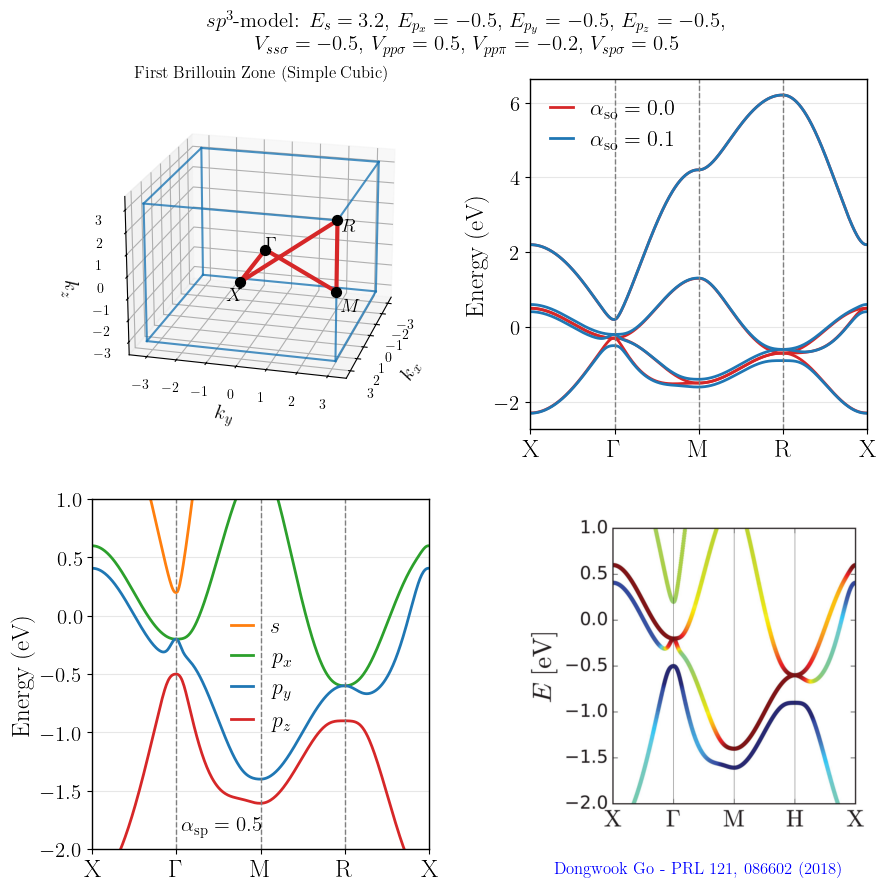

In [ ]:
def main_plot_BandStructure_Analytically():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(10, 10))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(2, 2, figure=fig, wspace=0.3)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0], projection='3d')
    ax2 = fig.add_subplot(gs_main[0, 1])
    ax3 = fig.add_subplot(gs_main[1, 0])
    ax4 = fig.add_subplot(gs_main[1, 1])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)
    plot_cubic_bz(ax1)
    plot_BandStructure_bands(ax2, bands, bands_soc, parameters, parameters_soc)
    plot_BandStructure_bands_soc(ax3, bands_soc, parameters_soc)
    plot_Go_fig_02b(ax4)

    title_geral = (
        parameters[0][:-1] +
        r"$E_{s} = " + str(parameters[2]) + r"$, " +
        r"$E_{p_x} = " + str(parameters[3]) + r"$, "  +
        r"$E_{p_y} = " + str(parameters[4]) + r"$, "  +
        r"$E_{p_z} = " + str(parameters[5]) + r"$, " + "\n" +
        r"$V_{ss\sigma} = " + str(parameters[6]) + r"$, " +
        r"$V_{pp\sigma} = " + str(parameters[7]) + r"$, " +
        r"$V_{pp\pi} = " + str(parameters[8]) + r"$, " +
        r"$V_{sp\sigma} = " + str(parameters[9]) + r"$"
    )

    fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.95)

    # 5. Closing the boxes (Box Style) in a robust way
    for ax in [ax2, ax3, ax4]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0)
        ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_BandStructure_Analytically()

#### __B.2. Diagonalization using pybinding__

Tight-binding modeling via Pybinding
- Without SOC

In [ ]:
def sp3_model_cubic(name, sp, override_params=None):
    """
    Implementation of a simple cubic lattice using Slater-Koster.
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    V_sp_sigma = sp  # Overwrite s-p hopping with spin value
    soc = 0.0        # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    # Create lattice with primitive vectors
    lat = pb.Lattice(a1=[a, 0, 0], a2=[0, a, 0], a3=[0, 0, a])

    # Atom position (all orbitals at the same position)
    pos = [0, 0, 0]

    """ Add sublattices with on-site energies """
    lat.add_sublattices(
        ( "s", pos,  E_s),
        ("px", pos, E_px),
        ("py", pos, E_py),
        ("pz", pos, E_pz)
    )

    """ Hopping in x-direction ([+/-1, 0, 0]) """
    lat.add_hoppings(
        # l=1, m=0, n=0
        ((1, 0, 0),  "s",  "s",   V_ss_sigma),  # Ess                                     = Vss_sigma
        ((1, 0, 0),  "s", "px",   V_sp_sigma),  # Espx  = l * Vsp_sigma                   = Vsp_sigma
        ((1, 0, 0), "px", "px",   V_pp_sigma),  # Epxpx = l^2 * Vpp_sigma + (1-l^2)Vpp_pi = Vpp_sigma
        ((1, 0, 0), "py", "py",      V_pp_pi),  # Epypy = m^2 * Vpp_sigma + (1-m^2)Vpp_pi = Vpp_pi
        ((1, 0, 0), "pz", "pz",      V_pp_pi),  # Epzpz = n^2 * Vpp_sigma + (1-n^2)Vpp_pi = Vpp_pi
        # l=-1, m=0, n=0
        ((-1, 0, 0),  "s", "px",  -V_sp_sigma),
    )

    """ Hopping in y-direction ([0, +/-1, 0]) """
    lat.add_hoppings(
        # l=0, m=1, n=0
        ((0, 1, 0),  "s",  "s",   V_ss_sigma),  # Ess   = Vss_sigma
        ((0, 1, 0),  "s", "py",   V_sp_sigma),  # Espy  = m * Vsp_sigma = Vsp_sigma
        ((0, 1, 0), "px", "px",      V_pp_pi),  # Epxpx = Vpp_pi
        ((0, 1, 0), "py", "py",   V_pp_sigma),  # Epypy = Vpp_sigma
        ((0, 1, 0), "pz", "pz",      V_pp_pi),  # Epzpz = Vpp_pi
        # l=0, m=-1, n=0
        (( 0,-1, 0),  "s", "py",  -V_sp_sigma),
    )

    """ Hopping in z-direction ([0, 0, +/-1]) """
    lat.add_hoppings(
        # l=0, m=0, n=1
        ((0, 0, 1),  "s",  "s",   V_ss_sigma),  # Ess = Vss_sigma
        ((0, 0, 1),  "s", "pz",   V_sp_sigma),  # Espz = n * Vsp_sigma = Vsp_sigma
        ((0, 0, 1), "px", "px",      V_pp_pi),  # Epxpx = Vpp_pi
        ((0, 0, 1), "py", "py",      V_pp_pi),  # Epypy = Vpp_pi
        ((0, 0, 1), "pz", "pz",   V_pp_sigma),  # Epzpz = Vpp_sigma
        # l=0, m=0, n=-1
        (( 0, 0,-1),  "s", "pz",  -V_sp_sigma),
    )

    return lat, parameters

- With SOC

In [ ]:
def sp3_model_cubic_SOC(name, sp, soc, override_params=None):
    """
    Simple cubic sp3 lattice with spin-orbit coupling (SOC).
    """
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, lsoc = params[name]

    V_sp_sigma = sp  # Overwrite s-p hopping with spin value
    lsoc = soc       # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    # Create lattice with primitive vectors
    lat = pb.Lattice(a1=[a, 0, 0], a2=[0, a, 0], a3=[0, 0, a])

    # Atom position (all orbitals at the same position)
    pos = [0, 0, 0]

    """ Add sublattices with on-site energies """
    lat.add_sublattices(
        ( "s_up", pos,  E_s), ( "s_dn", pos,  E_s),
        ("px_up", pos, E_px), ("px_dn", pos, E_px),
        ("py_up", pos, E_py), ("py_dn", pos, E_py),
        ("pz_up", pos, E_pz), ("pz_dn", pos, E_pz)
    )

    """ Add hoppings """
    directions = [
        ([1, 0, 0], "px"), # x
        ([0, 1, 0], "py"), # y
        ([0, 0, 1], "pz")  # z
    ]

    for vec, p_orb in directions:
        neg_vec = [-v for v in vec] # Vetor oposto (-1, 0, 0) etc.

        for spin in ["up", "dn"]:
            # s-s hopping (Simétrico)
            lat.add_hoppings((vec, f"s_{spin}", f"s_{spin}", V_ss_sigma))
            # s-p hopping (O segredo: sinal inverte na direção oposta)
            # Direção positiva (+x, +y, +z)
            lat.add_hoppings((vec, f"s_{spin}", f"{p_orb}_{spin}", V_sp_sigma))
            # Direção negativa (-x, -y, -z)
            lat.add_hoppings((neg_vec, f"s_{spin}", f"{p_orb}_{spin}", -V_sp_sigma))
            # p-p sigma (Simétrico)
            lat.add_hoppings((vec, f"{p_orb}_{spin}", f"{p_orb}_{spin}", V_pp_sigma))
            # p-p pi (Simétrico)
            others = [o for o in ["px", "py", "pz"] if o != p_orb]
            for other_p in others:
                lat.add_hoppings((vec, f"{other_p}_{spin}", f"{other_p}_{spin}", V_pp_pi))

    """ Spin-orbital coupling ([0,0,0]) """
    lat.add_hoppings(
        # Lz between px and py
        ([0, 0, 0], "px_up", "py_up", -1j * lsoc),
        ([0, 0, 0], "px_dn", "py_dn",  1j * lsoc),
        # L+/L- between pz e px/py
        ([0, 0, 0], "px_up", "pz_dn",       lsoc),
        ([0, 0, 0], "px_dn", "pz_up",      -lsoc),
        ([0, 0, 0], "py_up", "pz_dn", -1j * lsoc),
        ([0, 0, 0], "py_dn", "pz_up", -1j * lsoc)
    )

    return lat, parameters

Model initialization and bulk symmetry application
- **sp3_:** without SOC
- **sp3_soc:** with SOC

In [ ]:
sp3_, parameters_ = sp3_model_cubic("SP3-Go", sp = 0.5, override_params=None)
sp3_soc, parameters_soc = sp3_model_cubic_SOC("SP3-Go", sp = 0.5, soc = 0.1, override_params=None)
"""
Bulk Model Creation:
    Converts the sp3u and sp3d lattices into complete models.
    Applies translational symmetry (pb.translational_symmetry()) to simulate an infinite crystal.
"""
bulk_sp3_ = pb.Model(sp3_, pb.translational_symmetry())
bulk_sp3_soc = pb.Model(sp3_soc, pb.translational_symmetry())

Band structure solver initialization (numerical diagonalization of the Hamiltonian)

In [ ]:
solver_ = pb.solver.lapack(bulk_sp3_)       # Uses LAPACK (robust numerical library) for diagonalization
solver_soc = pb.solver.lapack(bulk_sp3_soc) # Uses LAPACK (robust numerical library) for diagonalization

Eigenvalue extraction along the high-symmetry path:

${\rm X} \to \Gamma \to {\rm M} \to {\rm R} \to {\rm X}$

In [ ]:
a = parameters_[1]
Gamma = [0, 0, 0]
X = [np.pi/a, 0, 0]
M = [np.pi/a, np.pi/a, 0]
R = [np.pi/a, np.pi/a, np.pi/a]

step = 0.01                               # "step" determines the resolution along the k-path

bands_bulk_sp3_ = solver_.calc_bands(X , Gamma, M, R, X, step=step)
bands_bulk_sp3_soc = solver_soc.calc_bands(X , Gamma, M, R, X, step=step)

In [ ]:
def plot_BandStructure_bands_Diagonalization(ax):
    label = r"Diagonalization"
    bands_bulk_sp3_.plot(ax=ax, color='tab:red', lw=2, label=label)
    #---------------------------------------------------------------------------
    dists = np.sqrt(np.sum(np.diff(full_path, axis=0)**2, axis=1))
    k_dist = np.concatenate(([0], np.cumsum(dists))) # Eixo X em unidades de 1/A
    lab1 = r"Analytically"
    ax.plot(k_dist, bands[:, 0], color='black', lw=2, linestyle="--", label=lab1)
    ax.plot(k_dist, bands[:, 1], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, bands[:, 2], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, bands[:, 3], color='black', lw=2, linestyle="--")
    #---------------------------------------------------------------------------

    xlabel = [r"${\rm X}$", r"$\Gamma$", r"${\rm M}$", r"${\rm R}$", r"$\Gamma$"]
    k_path = bands_bulk_sp3_.k_path
    k_axis = k_path.as_1d()
    indices = k_path.point_indices
    x_ticks = k_axis[indices]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xlabel, fontsize=15)
    ax.set_xlabel("")
    ax.set_xlim(x_ticks[0], x_ticks[-1])
    ax.set_ylabel("Energy (eV)", fontsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.grid(True, alpha=0.5)

    #ax.legend(fontsize=12,frameon=False,loc='center')
    # Pegamos todos os handles (linhas) e labels (textos) do gráfico
    handles, labels = ax.get_legend_handles_labels()

    # Criamos um dicionário para remover duplicatas (mantendo a ordem)
    by_label = dict(zip(labels, handles))

    # Desenha a legenda apenas com os itens únicos
    ax.legend(by_label.values(), by_label.keys(),
            fontsize=12, frameon=False, loc='best', handlelength=1.0)

    texto = r"$\alpha_{\rm sc} = " + str(parameters_[10]) + r"$"
    ax.text(0.5, 4.0, texto, fontsize=15, fontweight='bold')

    return ax

In [ ]:
def plot_BandStructure_bands_SOC_Diagonalization(ax):
    label = r"Diagonalization"
    bands_bulk_sp3_soc.plot(ax=ax, color='tab:red', lw=2, label=label)
    #---------------------------------------------------------------------------
    dists = np.sqrt(np.sum(np.diff(full_path, axis=0)**2, axis=1))
    k_dist = np.concatenate(([0], np.cumsum(dists))) # Eixo X em unidades de 1/A
    lab1 = r"Analytically"
    ax.plot(k_dist, 0.5*bands_soc[:, 6] + 0.5*bands_soc[:, 7], color='black', lw=2, linestyle="--", label=lab1)
    ax.plot(k_dist, 0.5*bands_soc[:, 5] + 0.5*bands_soc[:, 5], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, 0.5*bands_soc[:, 2] + 0.5*bands_soc[:, 3], color='black', lw=2, linestyle="--")
    ax.plot(k_dist, 0.5*bands_soc[:, 0] + 0.5*bands_soc[:, 1], color='black', lw=2, linestyle="--")
    #---------------------------------------------------------------------------
    xlabel = [r"${\rm X}$", r"$\Gamma$", r"${\rm M}$", r"${\rm R}$", r"$\Gamma$"]
    k_path = bands_bulk_sp3_.k_path
    k_axis = k_path.as_1d()
    indices = k_path.point_indices
    x_ticks = k_axis[indices]

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(xlabel, fontsize=15)
    ax.set_xlabel("")
    ax.set_xlim(x_ticks[0], x_ticks[-1])
    ax.set_ylabel("", fontsize=15)
    ax.tick_params(axis='both', labelsize=15) # Aplica a ambos os eixos
    ax.grid(True, alpha=0.5)

    #ax.legend(fontsize=12,frameon=False,loc='center')
    # Pegamos todos os handles (linhas) e labels (textos) do gráfico
    handles, labels = ax.get_legend_handles_labels()

    # Criamos um dicionário para remover duplicatas (mantendo a ordem)
    by_label = dict(zip(labels, handles))

    # Desenha a legenda apenas com os itens únicos
    ax.legend(by_label.values(), by_label.keys(),
            fontsize=12, frameon=False, loc='best', handlelength=1.0)

    texto = r"$\alpha_{\rm sc} = " + str(parameters_soc[10]) + r"$"
    ax.text(0.5, 4.0, texto, fontsize=15, fontweight='bold')

    return ax

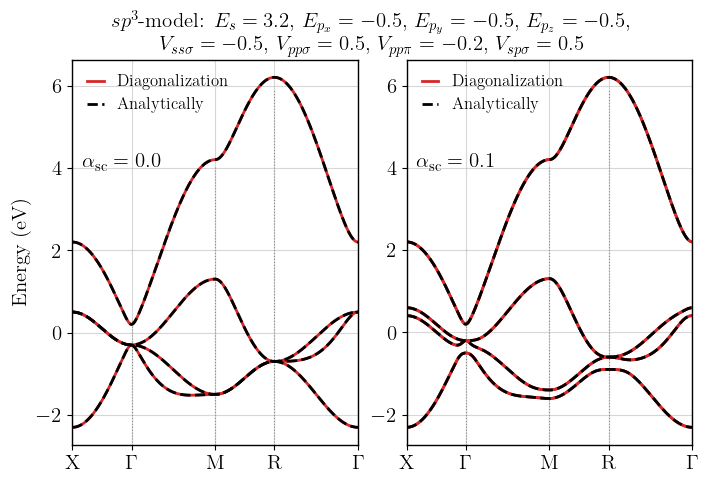

In [ ]:
def main_plot_BandStructure_Diagonalization():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(8, 5))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(1, 2, figure=fig, wspace=0.17)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax2 = fig.add_subplot(gs_main[0, 1])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)
    plot_BandStructure_bands_Diagonalization(ax1)
    plot_BandStructure_bands_SOC_Diagonalization(ax2)

    title_geral = (
        parameters_[0][:-1] +
        r"$E_{s} = " + str(parameters_[2]) + r"$, " +
        r"$E_{p_x} = " + str(parameters_[3]) + r"$, " +
        r"$E_{p_y} = " + str(parameters_[4]) + r"$, " +
        r"$E_{p_z} = " + str(parameters_[5]) + r"$, " + "\n" +
        r"$V_{ss\sigma} = " + str(parameters_[6]) + r"$, " +
        r"$V_{pp\sigma} = " + str(parameters_[7]) + r"$, " +
        r"$V_{pp\pi} = " + str(parameters_[8]) + r"$, " +
        r"$V_{sp\sigma} = " + str(parameters_[9]) + r"$"
    )

    fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.98)

    # 5. Closing the boxes (Box Style) in a robust way
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0) # Makes the border slightly sharper/cleaner
        ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_BandStructure_Diagonalization()

## **4. Hall Conductivity**

To calculate Hall conductivity (charge, spin, and orbital) to your $sp^3$ model, we need to implement the calculation of the Berry Curvature $\Omega_n(\mathbf{k})$ and then integrate it over the Brillouin zone.

### **A. Theoretical Background**

The Hall conductivity $\sigma_{xy}$ for a 2D system (or 3D system) is given by the Kubo formula:
$$\sigma_{xy} = -\frac{e^2}{\hbar} \sum_n \int \frac{d^2k}{(2\pi)^2} f_n(\mathbf{k}) \Omega_n^z(\mathbf{k})$$
Where the Berry Curvature for band $n$ is:
$$\Omega_n^z(\mathbf{k}) = -2\text{Im} \sum_{m \neq n} \frac{\langle n | v_x | m \rangle \langle m | v_y | n \rangle}{(E_n - E_m)^2}$$
To calculate Spin or Orbital Hall conductivities, we replace one velocity operator $v_x$ with the corresponding current operator:
- Spin Hall: $J_x^{\rm s} = \frac{1}{2} \{ s_z, v_x \} = \frac{\hbar}{4} \{ \sigma_z, v_x \}$
- Orbital Hall: $J_x^{\rm L} = \frac{1}{2} \{ L_z, v_x \}$

### **B. Implementation Steps**

Below is the code to extend our notebook. It includes the derivation of velocity operators and the calculation of the three Hall conductivities.

#### **B.1. Velocity Operators**

Using the analytical expressions for $H_{ss}, H_{p_xp_x},$ etc., from your *get_H* function, we define their derivatives with respect to $k_x$ and $k_y$.

In [ ]:
def get_operators(k, name, t_sp_sigma = 0.5, override_params=None):
    # Get parameters
    params = _default_sp3.copy()
    if override_params:
        params.update(override_params)

    a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc = params[name]
    if t_sp_sigma: V_sp_sigma = t_sp_sigma   # Overwrite s-p hopping with spin value
    #if lsoc: soc = lsoc                      # Overwrite Spin-orbit coupling value
    parameters = [r"$sp^3$-model:  ", a, E_s, E_px, E_py, E_pz, V_ss_sigma, V_pp_sigma, V_pp_pi, V_sp_sigma, soc]

    kx, ky, kz = k

    # 1. Velocity Operators (vx = dH/dkx, vy = dH/dky, vz = dH/dkz)
    """ vx = dH/dkx """
    dvss_dkx = -2 * a * V_ss_sigma * np.sin(kx*a)
    dvxx_dkx = -2 * a * V_pp_sigma * np.sin(kx*a)
    dvyy_dkx = -2 * a * V_pp_pi * np.sin(kx*a)
    dvzz_dkx = -2 * a * V_pp_pi * np.sin(kx*a)
    dvsx_dkx = 2j * a * V_sp_sigma * np.cos(kx*a)
    # Construct 4x4 vx (vy is similar but with ky)
    vx_4x4 = np.array([
        [         dvss_dkx, dvsx_dkx,        0,        0],
        [np.conj(dvsx_dkx), dvxx_dkx,        0,        0],
        [                0,        0, dvyy_dkx,        0],
        [                0,        0,        0, dvzz_dkx]
    ])
    # Expand to 8x8 (Spin-independent blocks)
    vx = np.block([
        [         vx_4x4, np.zeros((4,4))],
        [np.zeros((4,4)),          vx_4x4]
    ])

    """ vy = dH/dky """
    dvss_dky = -2 * a * V_ss_sigma * np.sin(ky*a)
    dvxx_dky = -2 * a * V_pp_pi * np.sin(ky*a)
    dvyy_dky = -2 * a * V_pp_sigma * np.sin(ky*a)
    dvzz_dky = -2 * a * V_pp_pi * np.sin(ky*a)
    dvsy_dky = 2j * a * V_sp_sigma * np.cos(ky*a)
    # Construct 4x4 vx (vy is similar but with ky)
    vy_4x4 = np.array([
        [         dvss_dky,        0, dvsy_dky,        0],
        [                0, dvxx_dky,        0,        0],
        [np.conj(dvsy_dky),        0, dvyy_dky,        0],
        [                0,        0,        0, dvzz_dky]
    ])
    # Expand to 8x8 (Spin-independent blocks)
    vy = np.block([
        [         vy_4x4, np.zeros((4,4))],
        [np.zeros((4,4)),          vy_4x4]
    ])

    # 2. Spin and Orbital Operators
    # Pauli sigma_z for the spin block
    sigma_z = np.block([
        [      np.eye(4), np.zeros((4,4))],
        [np.zeros((4,4)),      -np.eye(4)]
    ])

    # Lz operator (from your SOC section)
    Lz_p = np.array([
        [ 0, -1j, 0],
        [1j,   0, 0],
        [ 0,   0, 0]
    ])
    Lz = np.zeros((8,8), dtype=complex)
    Lz[1:4, 1:4] = Lz_p # Spin up p-orbitals
    Lz[5:8, 5:8] = Lz_p # Spin down p-orbitals

    # Current Operators: J = 1/2 * {O, v}
    js_x = 0.5 * 0.5 * (sigma_z @ vx + vx @ sigma_z) # Spin current
    jo_x = 0.5 * (Lz @ vx + vx @ Lz)           # Orbital current

    return vx, vy, js_x, jo_x

#### **B.2. Calculate Hall Conductivities**

The Hall conductivity for a given property (Charge, Spin, or Orbital) is calculated by integrating the generalized Berry curvature over the Brillouin zone.



In [ ]:
def compute_hall_vs_ef(name, grid_size, eta, t_sp_sigma, lsoc):
    # 1. Setup k-grid for the 3D Brillouin Zone
    a = _default_sp3[name][0]
    k_vals = np.linspace(-np.pi/a, np.pi/a, grid_size)

    all_energies = []
    all_c = [] # Charge Berry Curvature
    all_s = [] # Spin Berry Curvature
    all_o = [] # Orbital Berry Curvature

    # Pre-calculate constants
    k_cube = (2 * np.pi / a / (grid_size - 1))**3 if grid_size > 1 else 1

    # 2. Loop over 3D k-space
    for kx in k_vals:
        for ky in k_vals:
            for kz in k_vals:
                k = [kx, ky, kz]
                H, _ = get_H_SOC(k, name, t_sp_sigma=t_sp_sigma, lsoc=lsoc)
                energies, states = np.linalg.eigh(H)

                # Use your get_operators logic
                vx, vy, js_x, jo_x, _, _ = get_operators(k, name, t_sp_sigma=t_sp_sigma)

                # Transform operators to eigenbasis
                vx_n = states.conj().T @ vx @ states
                vy_n = states.conj().T @ vy @ states
                jsx_n = states.conj().T @ js_x @ states
                jox_n = states.conj().T @ jo_x @ states

                # Compute curvatures for each band n at this k-point
                for n in range(8):
                    om_c, om_s, om_o = 0, 0, 0
                    for m in range(8):
                        if n == m: continue
                        dE = energies[n] - energies[m]

                        # Use broadening (eta) to avoid divergence and smooth the plot
                        # The denominator becomes (dE^2 + eta^2)
                        denom = dE**2 + eta**2

                        #if abs(dE) < 1e-6: continue

                        om_c -= 2 * np.imag(vx_n[n, m] * vy_n[m, n]) / denom
                        om_s -= 2 * np.imag(jsx_n[n, m] * vy_n[m, n]) / denom
                        om_o -= 2 * np.imag(jox_n[n, m] * vy_n[m, n]) / denom

                    all_energies.append(energies[n])
                    all_c.append(om_c)
                    all_s.append(om_s)
                    all_o.append(om_o)

    ## 3. Process data for Fermi Level Plotting
    # Sorting and Cumulative Sum
    idx = np.argsort(all_energies)
    ef_axis = np.array(all_energies)[idx]
    # Normalizing by volume element and grid density
    norm = 1.0 / (grid_size**3)
    cond_c = np.cumsum(np.array(all_c)[idx]) * norm
    cond_s = np.cumsum(np.array(all_s)[idx]) * norm
    cond_o = np.cumsum(np.array(all_o)[idx]) * norm

    return ef_axis, cond_c, cond_s, cond_o

In [ ]:
ef, sig_c_sp050, sig_s_sp050, sig_o_sp050 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.10)
ef, sig_c_sp025, sig_s_sp025, sig_o_sp025 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.25, lsoc = 0.10)
ef, sig_c_sp010, sig_s_sp010, sig_o_sp010 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.10, lsoc = 0.10)
ef, sig_c_sp000, sig_s_sp000, sig_o_sp000 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.00, lsoc = 0.10)

In [ ]:
ef, sig_c_so030, sig_s_so030, sig_o_so030 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.30)
ef, sig_c_so010, sig_s_so010, sig_o_so010 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.10)
ef, sig_c_so005, sig_s_so005, sig_o_so005 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.05)
ef, sig_c_so002, sig_s_so002, sig_o_so002 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.02)
ef, sig_c_so000, sig_s_so000, sig_o_so000 = compute_hall_vs_ef("SP3-Go", grid_size = 60, eta = 0.01, t_sp_sigma = 0.50, lsoc = 0.00)

In [ ]:
def plot_HallConductivity_orbital_sp(ax):

    ax.plot(10*sig_o_sp000, ef, color='black', lw=1, ls="-", label=r"$V_{sp\sigma}=0.00$")
    ax.plot(10*sig_o_sp010, ef, color='tab:red', lw=1, ls="-", label=r"$V_{sp\sigma}=0.10$")
    ax.plot(10*sig_o_sp025, ef, color='tab:green', lw=1, ls="-", label=r"$V_{sp\sigma}=0.25$")
    ax.plot(10*sig_o_sp050, ef, color='tab:blue', lw=1, ls="-", label=r"$V_{sp\sigma}=0.50$")

    ax.legend(fontsize=11, loc='best', frameon=False, handlelength=1.0)
    #ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)

    ax.set_xticks(np.arange(-1., 3.5, 1.))
    ax.set_xlim(-0.5, 3.)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel(r"$\sigma_{\rm OH}$ $(\times 10 \; e/2\pi)$", fontsize=15)

    ax.set_yticks(np.arange(-2, 1.1, 0.5))
    ax.set_ylim(-2., 1.)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel("Fermi Energy (eV)", fontsize=15)

    ax.grid(alpha=0.3)

    return ax

In [ ]:
def plot_HallConductivity_spin_sp(ax):

    ax.plot(10*sig_s_sp000, ef, color='black', lw=1, ls="-", label=r"$V_{sp\sigma}=0.00$")
    ax.plot(10*sig_s_sp010, ef, color='tab:red', lw=1, ls="-", label=r"$V_{sp\sigma}=0.10$")
    ax.plot(10*sig_s_sp025, ef, color='tab:green', lw=1, ls="-", label=r"$V_{sp\sigma}=0.25$")
    ax.plot(10*sig_s_sp050, ef, color='tab:blue', lw=1, ls="-", label=r"$V_{sp\sigma}=0.50$")

    ax.legend(fontsize=11, loc='best', frameon=False, handlelength=1.0)
    #ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)

    ax.set_xticks(np.arange(-2., 1.5, 0.5))
    ax.set_xlim(-1., 0.5)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel(r"$\sigma_{\rm SH}$ $(\times 10 \; e/2\pi)$", fontsize=15)

    ax.set_yticks(np.arange(-2, 1.1, 0.5))
    ax.set_ylim(-2., 1.)
    ax.tick_params(axis='y', labelsize=15)
    #ax.set_ylabel("Fermi Energy (eV)", fontsize=15)

    ax.grid(alpha=0.3)

    return ax

In [ ]:
def plot_HallConductivity_orbital_so(ax):

    ax.plot(10*sig_o_so000, ef, color='black', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.00$")
    ax.plot(10*sig_o_so002, ef, color='tab:red', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.02$")
    ax.plot(10*sig_o_so005, ef, color='tab:orange', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.05$")
    ax.plot(10*sig_o_so010, ef, color='tab:green', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.10$")
    ax.plot(10*sig_o_so030, ef, color='tab:blue', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.30$")

    ax.legend(fontsize=11, loc='best', frameon=False, handlelength=1.0)
    #ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)

    ax.set_xticks(np.arange(-1., 3.5, 1.))
    ax.set_xlim(-0.5, 3.)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel(r"$\sigma_{\rm OH}$ $(\times 10 \; e/2\pi)$", fontsize=15)

    ax.set_yticks(np.arange(-2, 1.1, 0.5))
    ax.set_ylim(-2., 1.)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylabel("Fermi Energy (eV)", fontsize=15)

    ax.grid(alpha=0.3)

    return ax

In [ ]:
def plot_HallConductivity_spin_so(ax):

    ax.plot(10*sig_s_so000, ef, color='black', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.00$")
    ax.plot(10*sig_s_so002, ef, color='tab:red', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.02$")
    ax.plot(10*sig_s_so005, ef, color='tab:orange', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.05$")
    ax.plot(10*sig_s_so010, ef, color='tab:green', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.10$")
    ax.plot(10*sig_s_so030, ef, color='tab:blue', lw=1, ls="-", label=r"$\alpha_{\rm so}=0.30$")

    ax.legend(fontsize=11, loc='best', frameon=False, handlelength=1.0)
    #ax.axvline(n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(2*n_pts, color='tab:gray', linestyle='--', lw=1)
    #ax.axvline(3*n_pts, color='tab:gray', linestyle='--', lw=1)

    ax.set_xticks(np.arange(-3., 3.5, 0.5))
    ax.set_xlim(-1., 0.5)
    ax.tick_params(axis='x', labelsize=15)
    ax.set_xlabel(r"$\sigma_{\rm OH}$ $(\times 10 \; e/2\pi)$", fontsize=15)

    ax.set_yticks(np.arange(-2, 1.1, 0.5))
    ax.set_ylim(-2., 1.)
    ax.tick_params(axis='y', labelsize=15)
    #ax.set_ylabel("Fermi Energy (eV)", fontsize=15)

    ax.grid(alpha=0.3)

    return ax

In [ ]:
def plot_Go_fig_03a(ax):
    path = "/content/drive/MyDrive/KITE-2026/sp3-model/Cubic-Lattice"
    try:
        img = mpimg.imread(f'{path}/Ref_Go_01.png')
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, "PRL 121, 086602 (2018)",
                color='blue',
                fontsize=12,
                ha='center',
                va='top',
                transform=ax.transAxes) # 'transAxes' garante que 0 e 1 sejam os limites do box
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')
        print("Warning: The PNG file was not found.")

    return ax

In [ ]:
def plot_Go_fig_03b(ax):
    path = "/content/drive/MyDrive/KITE-2026/sp3-model/Cubic-Lattice"
    try:
        img = mpimg.imread(f'{path}/Ref_Go_02.png')
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, "PRL 121, 086602 (2018)",
                color='blue',
                fontsize=12,
                ha='center',
                va='top',
                transform=ax.transAxes) # 'transAxes' garante que 0 e 1 sejam os limites do box
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')
        print("Warning: The PNG file was not found.")

    return ax

In [ ]:
def plot_Go_fig_S2a(ax):
    path = "/content/drive/MyDrive/KITE-2026/sp3-model/Cubic-Lattice"
    try:
        img = mpimg.imread(f'{path}/Ref_Go_03.png')
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, "PRL 121, 086602 (2018)",
                color='blue',
                fontsize=12,
                ha='center',
                va='top',
                transform=ax.transAxes) # 'transAxes' garante que 0 e 1 sejam os limites do box
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')
        print("Warning: The PNG file was not found.")

    return ax

In [ ]:
def plot_Go_fig_S2b(ax):
    path = "/content/drive/MyDrive/KITE-2026/sp3-model/Cubic-Lattice"
    try:
        img = mpimg.imread(f'{path}/Ref_Go_04.png')
        ax.imshow(img)
        ax.axis('off')
        ax.text(0.5, -0.1, "PRL 121, 086602 (2018)",
                color='blue',
                fontsize=12,
                ha='center',
                va='top',
                transform=ax.transAxes) # 'transAxes' garante que 0 e 1 sejam os limites do box
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center')
        ax.axis('off')
        print("Warning: The PNG file was not found.")

    return ax

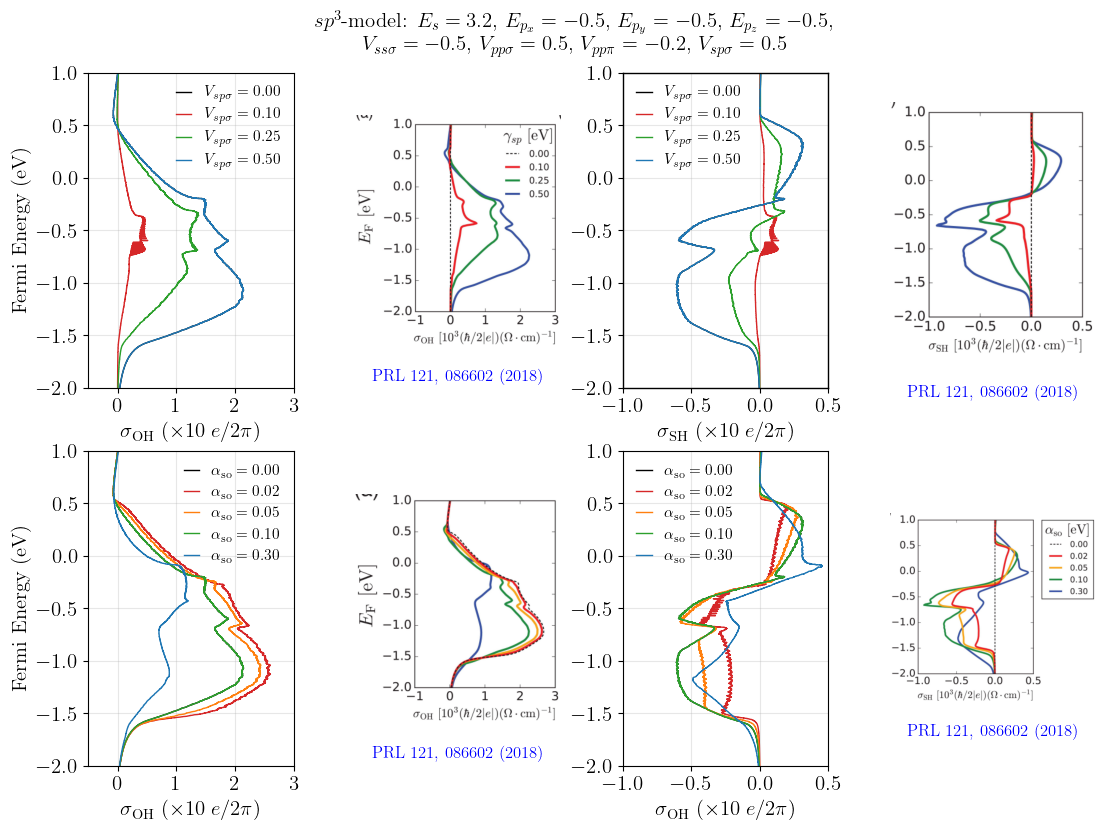

In [ ]:
def main_plot_BandStructure_Analytically():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(13, 9))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(2, 4, figure=fig, wspace=0.3)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax2 = fig.add_subplot(gs_main[0, 1])
    ax3 = fig.add_subplot(gs_main[0, 2])
    ax4 = fig.add_subplot(gs_main[0, 3])
    ax5 = fig.add_subplot(gs_main[1, 0])
    ax6 = fig.add_subplot(gs_main[1, 1])
    ax7 = fig.add_subplot(gs_main[1, 2])
    ax8 = fig.add_subplot(gs_main[1, 3])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)
    plot_HallConductivity_orbital_sp(ax1)
    plot_Go_fig_03a(ax2)
    plot_HallConductivity_spin_sp(ax3)
    plot_Go_fig_03b(ax4)
    plot_HallConductivity_orbital_so(ax5)
    plot_Go_fig_S2a(ax6)
    plot_HallConductivity_spin_so(ax7)
    plot_Go_fig_S2b(ax8)

    title_geral = (
        parameters[0][:-1] +
        r"$E_{s} = " + str(parameters[2]) + r"$, " +
        r"$E_{p_x} = " + str(parameters[3]) + r"$, "  +
        r"$E_{p_y} = " + str(parameters[4]) + r"$, "  +
        r"$E_{p_z} = " + str(parameters[5]) + r"$, " + "\n" +
        r"$V_{ss\sigma} = " + str(parameters[6]) + r"$, " +
        r"$V_{pp\sigma} = " + str(parameters[7]) + r"$, " +
        r"$V_{pp\pi} = " + str(parameters[8]) + r"$, " +
        r"$V_{sp\sigma} = " + str(parameters[9]) + r"$"
    )

    fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.95)

    # 5. Closing the boxes (Box Style) in a robust way
    for ax in [ax2, ax3, ax4]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('black')
            spine.set_linewidth(1.0)
        ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_BandStructure_Analytically()

In [ ]:
def get_path_curvatures(full_path, name, eta=0.01):
    n_k = len(full_path)
    n_bands = 8

    # Storage for energies and curvatures
    path_energies = np.zeros((n_k, n_bands))
    path_om_s = np.zeros((n_k, n_bands))
    path_om_o = np.zeros((n_k, n_bands))

    for i, k in enumerate(full_path):
        # 1. Get H and diagonalize
        H, _ = get_H_SOC(k, name)
        energies, states = np.linalg.eigh(H)
        path_energies[i, :] = energies

        # 2. Get operators (using your existing function)
        vx, vy, js_x, jo_x = get_operators(k, name)

        # 3. Transform operators to eigenbasis
        vy_n = states.conj().T @ vy @ states
        jsx_n = states.conj().T @ js_x @ states
        jox_n = states.conj().T @ jo_x @ states

        # 4. Compute curvature for each band n
        for n in range(n_bands):
            om_s, om_o = 0, 0
            for m in range(n_bands):
                if n == m: continue

                dE = energies[n] - energies[m]
                denom = dE**2 + eta**2

                # Spin curvature: Im[ <n|jsx|m><m|vy|n> ]
                om_s -= 2 * np.imag(jsx_n[n, m] * vy_n[m, n]) / denom
                # Orbital curvature: Im[ <n|jox|m><m|vy|n> ]
                om_o -= 2 * np.imag(jox_n[n, m] * vy_n[m, n]) / denom

            path_om_s[i, n] = om_s
            path_om_o[i, n] = om_o

    return path_energies, path_om_s, path_om_o

In [ ]:
# --- Execution ---
energies, om_s, om_o = get_path_curvatures(full_path, "SP3-Go")

In [ ]:
def plot_projected_bands(ax, energies, conductivity, nome):
    n_k, n_bands = energies.shape
    k_axis = np.arange(n_k) # Simple index-based axis for the path

    # Normalize color scale based on the data
    v_max = np.max(np.abs(conductivity)) * 0.5 # Adjust contrast
    norm = plt.Normalize(-v_max, v_max)

    # Option 01:
    #cmap = plt.get_cmap('RdBu_r') # Red/Blue for +/- curvature
    #cmap = plt.get_cmap('seismic') # Red/Blue for +/- curvature
    #cmap = plt.get_cmap('bwr') # Red/Blue for +/- curvature
    #cmap = plt.get_cmap('jet') # Red/Blue for +/- curvature

    # Option 02:
    #colors = ["blue", "black", "red"]
    #custom_bbr = LinearSegmentedColormap.from_list("blue_black_red", colors)
    #cmap = custom_bbr

    # Option 03:
    #nodes = [0.0, 0.49, 0.5, 0.51, 1.0]
    #colors = ["blue", "blue", "black", "red", "red"]
    #custom_bbr = LinearSegmentedColormap.from_list("sharp_bbr", list(zip(nodes, colors)))
    #cmap = custom_bbr

    # Option 04:
    nodes = [0.0, 0.48, 0.5, 0.52, 1.0]
    colors = ["blue", "blue", "grey", "red", "red"]
    custom_bbr = LinearSegmentedColormap.from_list("gradient_bbr", list(zip(nodes, colors)))
    cmap = custom_bbr

    for b in range(n_bands):
        # Create segments for LineCollection
        points = np.array([k_axis, energies[:, b]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        lc = LineCollection(segments, cmap=cmap, norm=norm)
        lc.set_array(conductivity[:, b])
        lc.set_linewidth(2.5)
        ax.add_collection(lc)

    ax.set_xlim(0, n_k - 1)
    ax.set_ylim(np.min(energies)-1, np.max(energies)+1)
    #ax.set_xlabel(r"k-path")
    ax.set_ylabel(r"Energy (eV)")

    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, ax=ax, label='Curvature (arb. units)')

    # Add vertical lines for high symmetry points
    for i in range(1, 4):
        ax.axvline(x=i * (n_k // 4), color='k', linestyle='--', alpha=0.5)
    ax.set_xticks([0, n_k//4, 2*n_k//4, 3*n_k//4, n_k-1])
    ax.set_xticklabels([r'X', r'$\Gamma$', r'M', r'R', r'X'])

    return ax

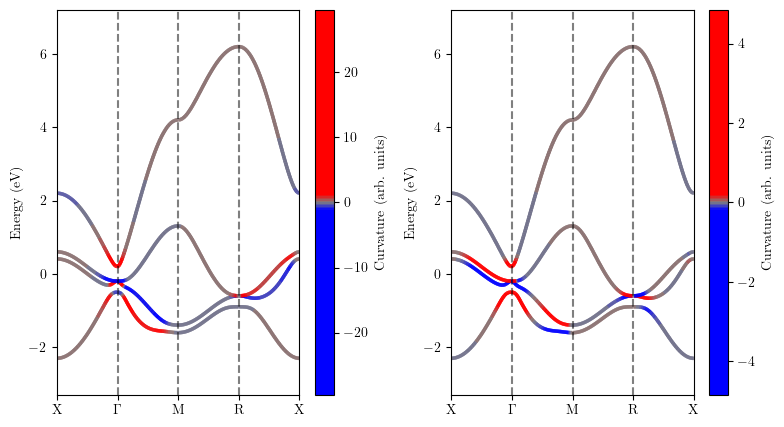

In [ ]:
def main_plot_Cond_BandStructure_Analytically_projected():
    # 1. Adjust the figure size to fit both plots side-by-side
    fig = plt.figure(figsize=(9, 5))

    # 2. Create the gridspec
    gs_main = gridspec.GridSpec(1, 2, figure=fig, wspace=0.3)

    # 3. Create the subplots
    ax1 = fig.add_subplot(gs_main[0, 0])
    ax2 = fig.add_subplot(gs_main[0, 1])

    # 4. Call your functions (ensure BrillouinZone ends with ':' as corrected)
    plot_projected_bands(ax1, energies, om_o, "with SOC")
    plot_projected_bands(ax2, energies, om_s, "with SOC")

    #title_geral = (
    #    parameters[0][:-1] +
    #    r"$E_{s} = " + str(parameters[2]) + r"$, " +
    #    r"$E_{p_x} = " + str(parameters[3]) + r"$, "  +
    #    r"$E_{p_y} = " + str(parameters[4]) + r"$, "  +
    #    r"$E_{p_z} = " + str(parameters[5]) + r"$, " + "\n" +
    #    r"$V_{ss\sigma} = " + str(parameters[6]) + r"$, " +
    #    r"$V_{pp\sigma} = " + str(parameters[7]) + r"$, " +
    #    r"$V_{pp\pi} = " + str(parameters[8]) + r"$, " +
    #    r"$V_{sp\sigma} = " + str(parameters[9]) + r"$"
    #)

    #fig.suptitle(title_geral, fontsize=15, fontweight='bold', y=0.95)

    # 5. Closing the boxes (Box Style) in a robust way
    #for ax in [ax2, ax3, ax4]:
    #    for spine in ax.spines.values():
    #        spine.set_visible(True)
    #        spine.set_color('black')
    #        spine.set_linewidth(1.0)
    #    ax.set_frame_on(True)

    # 6. Finalization
    # tight_layout usually works better than subplots_adjust to prevent label clipping
    plt.tight_layout()
    #plt.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95,
    #                      hspace=0.4, wspace=0.4)

    plt.show()
    plt.close()

if __name__ == "__main__":
    main_plot_Cond_BandStructure_Analytically_projected()

### __C. Density of States (Chebyshev Polynomials)__

## **5. Disorder Effects on Orbital Hall Transport Using Chebyshev Expansion**

### **A. Anderson-like site potential fluctuations**

### **B. Vacancies**

### **C. Bond disorder**